# Notebook 01 - Exploring the Synthetic CLD dataset

This notebook validates that the synthetic Cell Line Development (CLD) dataset generated by 'generate_synthetic_cld.py' looks realistic and is ML-ready.

We will:
1. Connect to the SQLite database ('cld.db)
2. Check table row counts (sanity check)
3. Join assay results with passage metadata
4. Visualize key CLD trends across passages:
 - Titer (productivity)
 - VCD (growth)
 - Viability (cell health)
 - Aggregation (quality proxy)
5. Inspect stability labels and batch effects

## 1) Import & DB connection

We import standard analysis libraries and connect to the SQLite database created by the generator.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DB_PATH = "../data/synthetic/raw/cld.db"
conn = sqlite3.connect(DB_PATH)

print("Connected to:", DB_PATH)

Connected to: ../data/synthetic/raw/cld.db


## 2) Table row count sanity check

This checks whether the dataset size matches expectations:
- ~500 clones
- 500 x 30 = 15,000 passage data
- 15,000 x 4 assay => appx 60,000 assay rows
- ~500 stability labels

In [2]:
tables = [
    "product","host_cell","vector","cell_line",
    "batch","clone","passage","process_condition",
    "assay_result","stability_test"
]

for t in tables:
    n = pd.read_sql_query(f"SELECT COUNT(*) AS n FROM {t}", conn)["n"][0]
    print(f"{t:16s} {n}")

product          1
host_cell        1
vector           1
cell_line        1
batch            30
clone            500
passage          15000
process_condition 15000
assay_result     60000
stability_test   500


## 3) Build an analysis table by joining assays with passage metadata

'assay_result' contains measured values (titer/VCD/viability/aggregation) per passage.

We join it with the 'passage' table to attach:
- clone_id
- passage_number
- phase (early/mid/late)

This gives us a single analysis-ready table for plotting and feature engineering.

In [3]:
assay = pd.read_sql_query("""
SELECT 
  ar.assay_id,
  ar.assay_type,
  ar.value,
  ar.unit,
  ar.method,
  ar.batch_id,
  p.clone_id,
  p.passage_number,
  p.phase
FROM assay_result ar
JOIN passage p
  ON p.passage_id = ar.passage_id
""", conn)

assay.head()

,assay_id,assay_type,value,unit,method,batch_id,clone_id,passage_number,phase
0,ASSAY_CLONE_0001_P01_titer,titer,2.889395e+00,g/L,ELISA,B_P01,CLONE_0001,1,early
1,ASSAY_CLONE_0001_P01_vcd,vcd,9.043899e+06,cells/mL,Vi-CELL,B_P01,CLONE_0001,1,early
2,ASSAY_CLONE_0001_P01_viability,viability,9.377135e+01,%,Vi-CELL,B_P01,CLONE_0001,1,early
3,ASSAY_CLONE_0001_P01_aggregation,aggregation,8.058368e+00,%,SEC-HPLC,B_P01,CLONE_0001,1,early
4,ASSAY_CLONE_0001_P02_titer,titer,2.846536e+00,g/L,ELISA,B_P02,CLONE_0001,2,early


## 4) Sample a few clones for visualization

We randomly select a small set of clones to visually inspect CLD trends across passages.

In [4]:
all_clones = assay["clone_id"].unique()
sample_clones = np.random.choice(all_clones, size=6, replace=False)
sample_clones

array(['CLONE_0053', 'CLONE_0279', 'CLONE_0328', 'CLONE_0314',
       'CLONE_0422', 'CLONE_0444'], dtype=object)

## 5) Titer vs passage (productivity trend)

Titer is a key CLD readout. (e.g., ELISA/Octect)
We expect:
- different clones to have different baseline titers
- many clones to show decreasing titer across passages depending on stability.

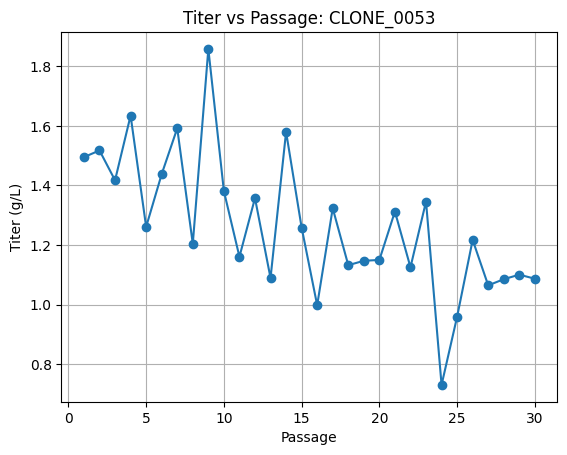

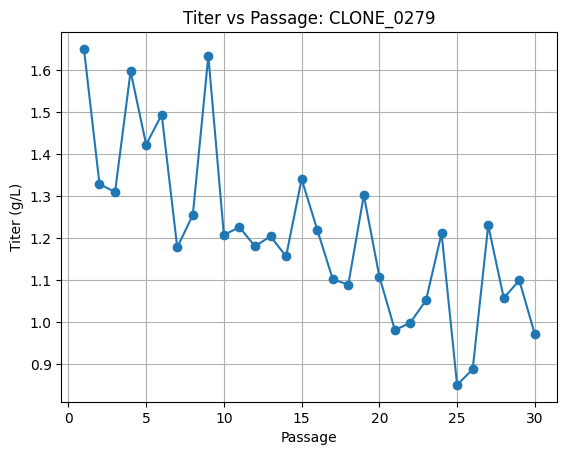

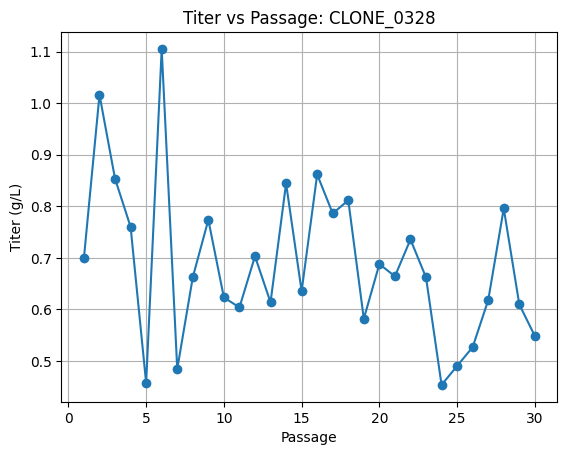

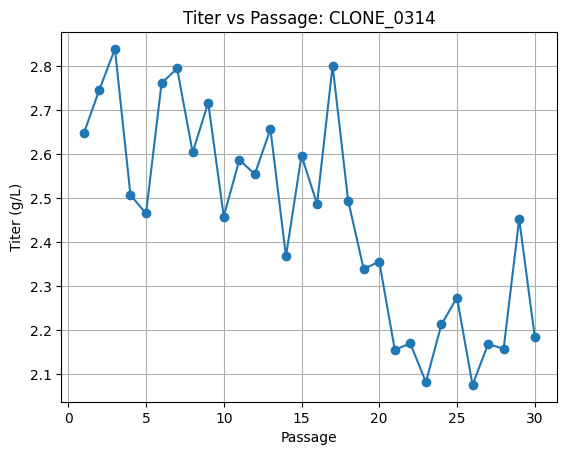

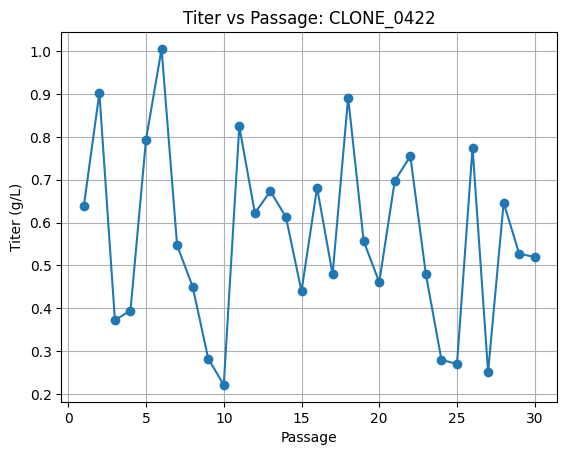

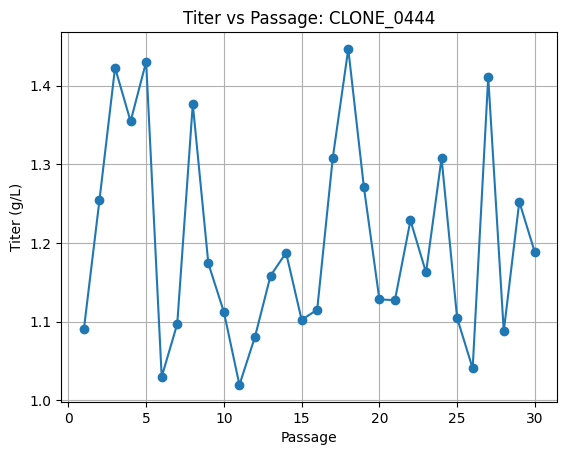

In [5]:
for cid in sample_clones:
    df = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "titer")].sort_values("passage_number")
    plt.figure()
    plt.plot(df["passage_number"], df["value"], marker="o")
    plt.title(f"Titer vs Passage: {cid}")
    plt.xlabel("Passage")
    plt.ylabel("Titer (g/L)")
    plt.grid(True)
    plt.show()

## 6) VCD & Viability vs passage (growth and cell health)

VCD (Viable Cell Density) and viability are typical upstream process readouts (e.g., Vi-CELL).

In this synthetic model we expect:
- VCD/viability may improve over passages as cells adapt and expression burden decreases.
- Trends vary by clone due to different latent states and batch effects

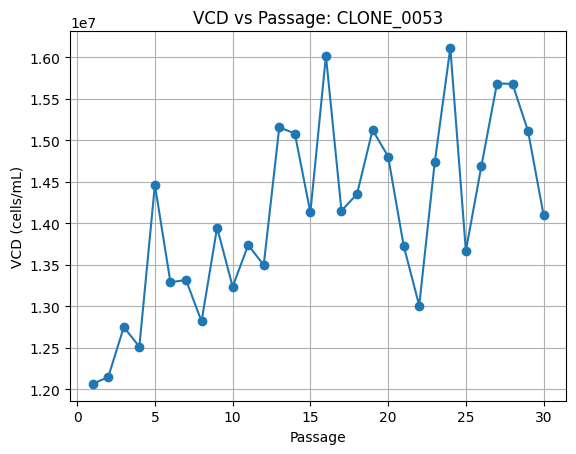

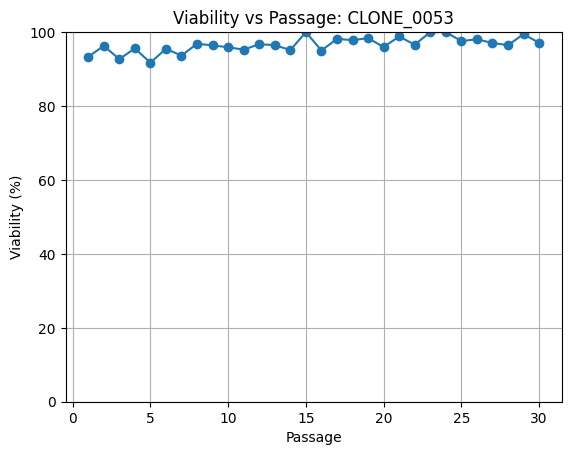

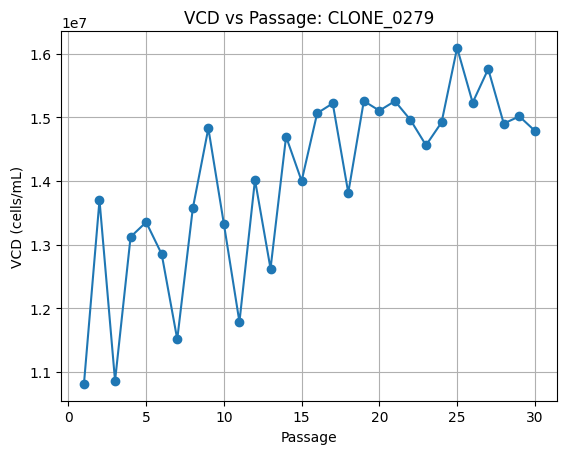

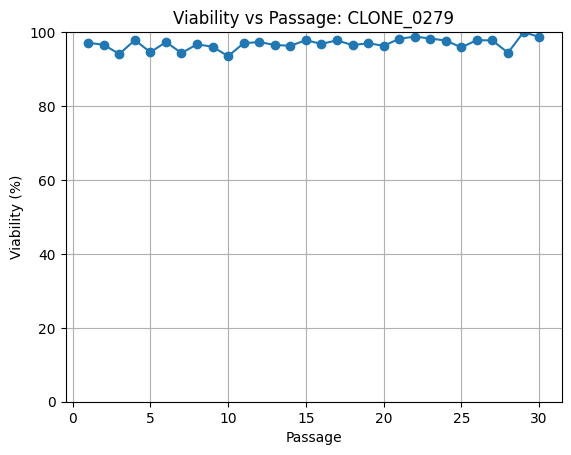

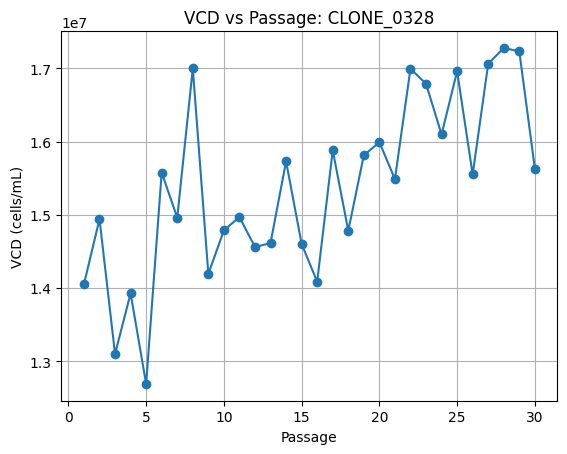

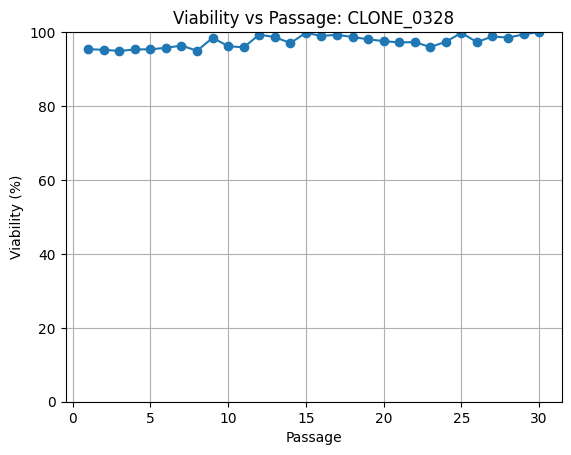

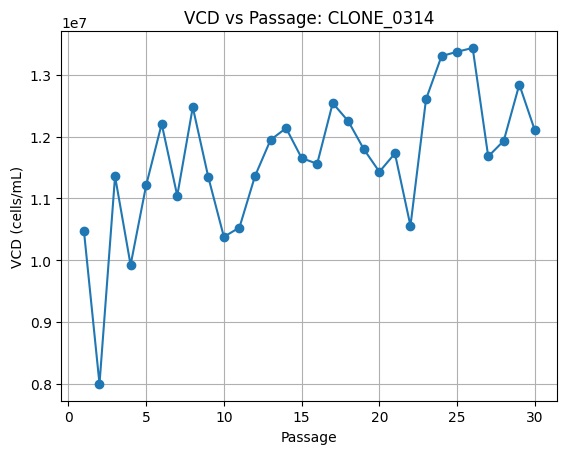

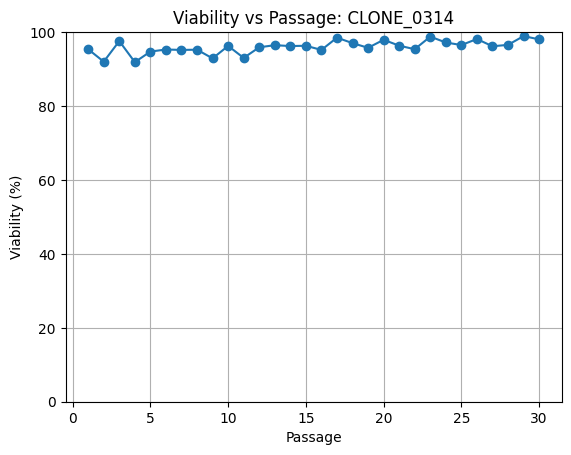

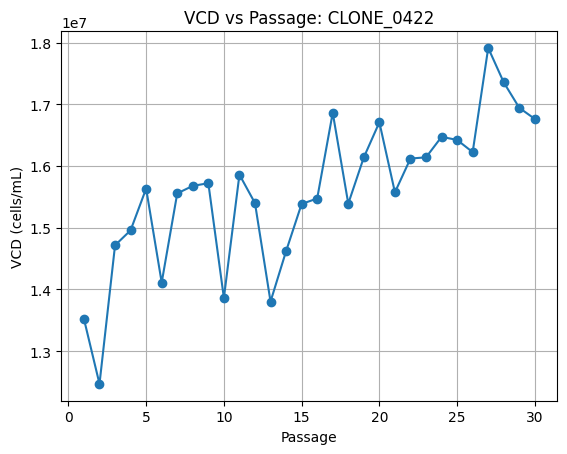

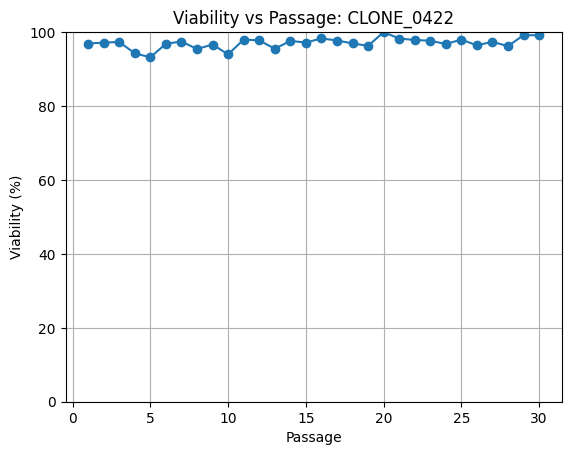

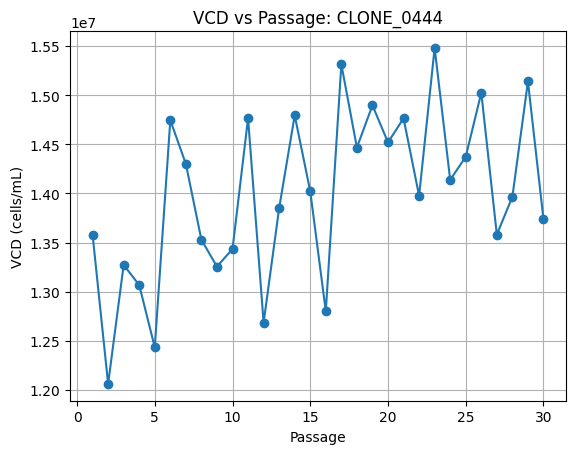

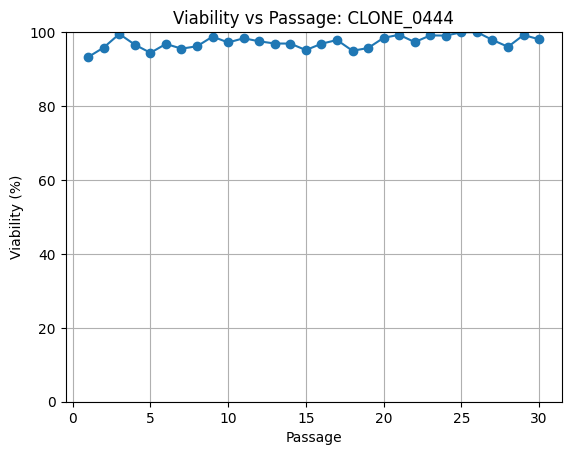

In [6]:
for cid in sample_clones:
    df_vcd = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "vcd")].sort_values("passage_number")
    df_viab = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "viability")].sort_values("passage_number")

    plt.figure()
    plt.plot(df_vcd["passage_number"], df_vcd["value"], marker="o")
    plt.title(f"VCD vs Passage: {cid}")
    plt.xlabel("Passage")
    plt.ylabel("VCD (cells/mL)")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(df_viab["passage_number"], df_viab["value"], marker="o")
    plt.title(f"Viability vs Passage: {cid}")
    plt.xlabel("Passage")
    plt.ylabel("Viability (%)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.show()

## 7) Aggregation vs passage (qaulity proxy)

Aggregation is used as a simplified quality metric proxy (SEC-HPLC-like behavior).

In the simulator, aggregation increases when:
- intrinsic quality potential is lower
- stress is higher

This helps create realistic productivity-quality tradeoffs for ML experiments.

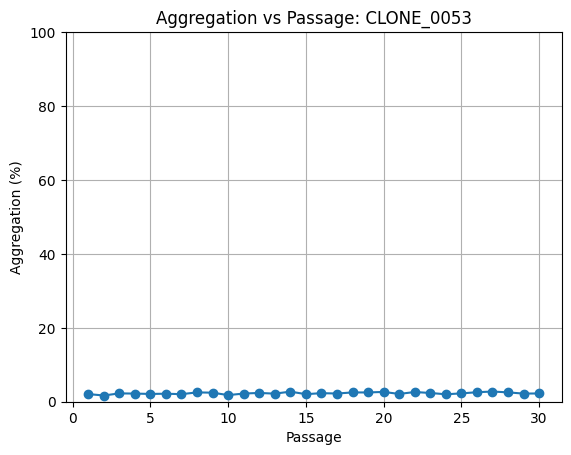

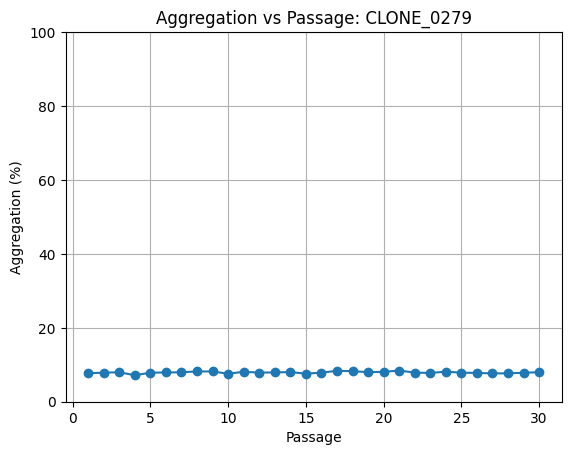

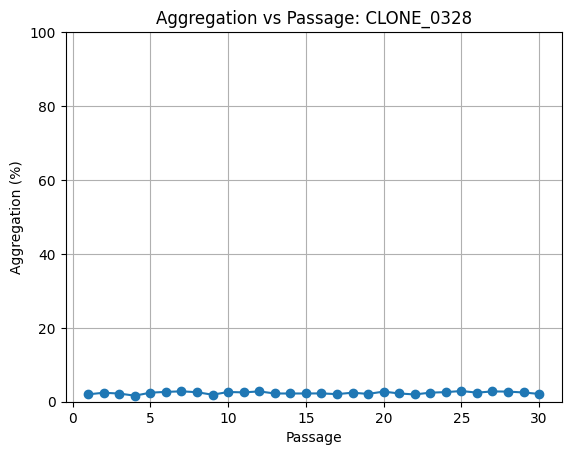

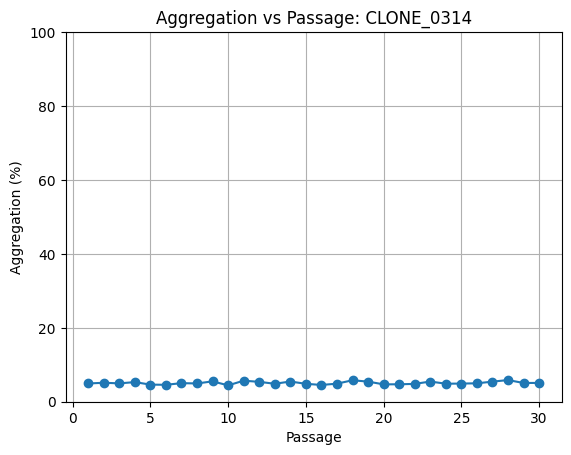

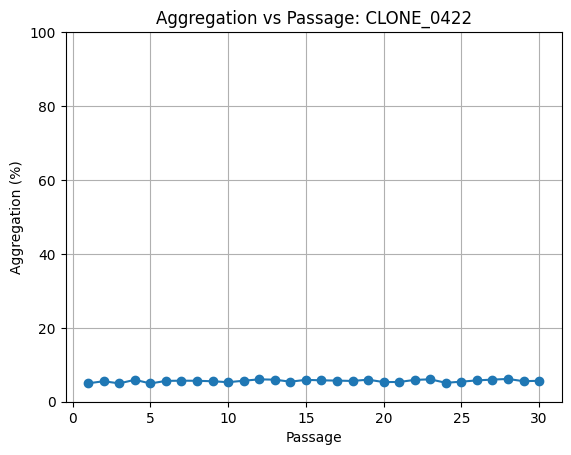

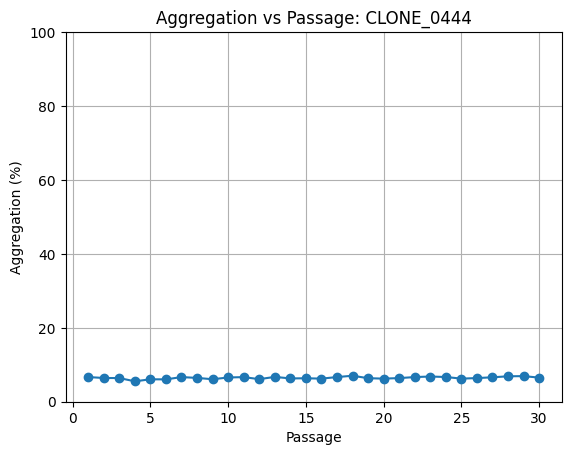

In [7]:
for cid in sample_clones:
    df = assay[(assay["clone_id"] == cid) & (assay["assay_type"] == "aggregation")].sort_values("passage_number")
    plt.figure()
    plt.plot(df["passage_number"], df["value"], marker="o")
    plt.title(f"Aggregation vs Passage: {cid}")
    plt.xlabel("Passage")
    plt.ylabel("Aggregation (%)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.show()

## 8) Inspect stability labels

The 'stability_test' table stores a stability outcome per clone.
We use a robust label (early vs late averate titer drop) to reduce sensitivity to single-passage noise.

In [8]:
stb = pd.read_sql_query("""
SELECT stability_id, clone_id, start_passage, end_passage, productivity_drop_pct, metric_type
FROM stability_test
""", conn)

stb.describe()

,start_passage,end_passage,productivity_drop_pct
count,500.0,500.0,500.000000
mean,1.0,30.0,0.193453
std,0.0,0.0,0.124071
min,1.0,30.0,-0.541665
25%,1.0,30.0,0.124572
50%,1.0,30.0,0.200021
75%,1.0,30.0,0.267370
max,1.0,30.0,0.562787


## 9) Plot Stability label distribution

This histogram sohws how stability outcomes are distributed across clones.
We expect a broad distribution where:
- values near 0 indicate stable clones.
- higher values indicate unstable clones (larger productivity drop)

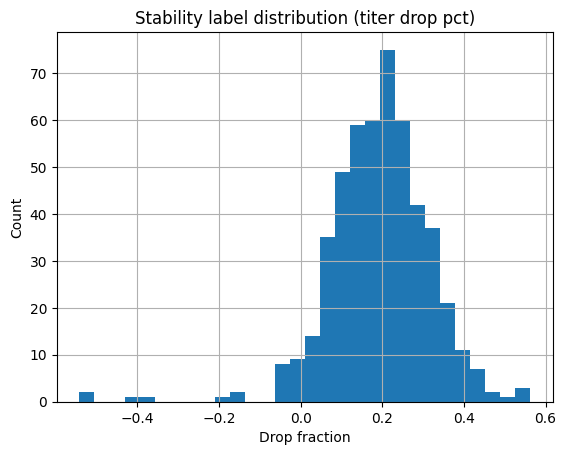

In [9]:
plt.figure()
plt.hist(stb["productivity_drop_pct"].dropna(), bins=30)
plt.title("Stability label distribution (titer drop pct)")
plt.xlabel("Drop fraction")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## 10) Early productivity vs stability relationship (optional)

This scatter plot checks how early productivity (mean titer in early passages) relates to stability (late drop).
In real CLD, high early productivity does not always guarantee long-term stability.

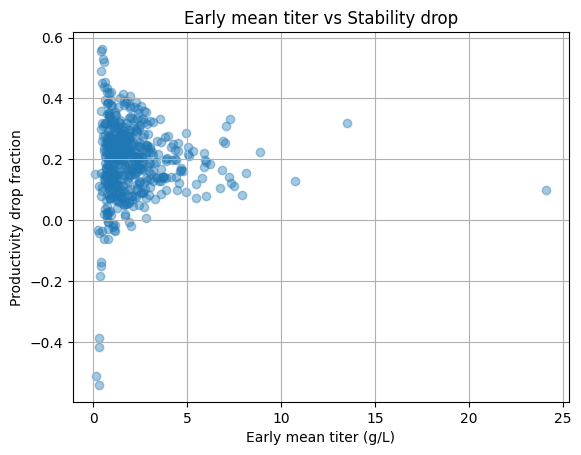

,early_mean_titer,productivity_drop_pct
early_mean_titer,1.000000,0.002102
productivity_drop_pct,0.002102,1.000000


In [10]:
early_max = 5

titer_df = assay[assay["assay_type"] == "titer"].copy()

early_mean = (
    titer_df[titer_df["passage_number"] <= early_max]
    .groupby("clone_id")["value"]
    .mean()
    .rename("early_mean_titer")
    .reset_index()
)

merged = early_mean.merge(stb[["clone_id","productivity_drop_pct"]], on="clone_id", how="inner")

plt.figure()
plt.scatter(merged["early_mean_titer"], merged["productivity_drop_pct"], alpha=0.4)
plt.title("Early mean titer vs Stability drop")
plt.xlabel("Early mean titer (g/L)")
plt.ylabel("Productivity drop fraction")
plt.grid(True)
plt.show()

merged.corr(numeric_only=True)

## 11) Batch effect check (optional)

Batch effects simulate systematic run-to-run drift (operator/day/platform effects).
We check whether mean titer shifts slightly across batches.

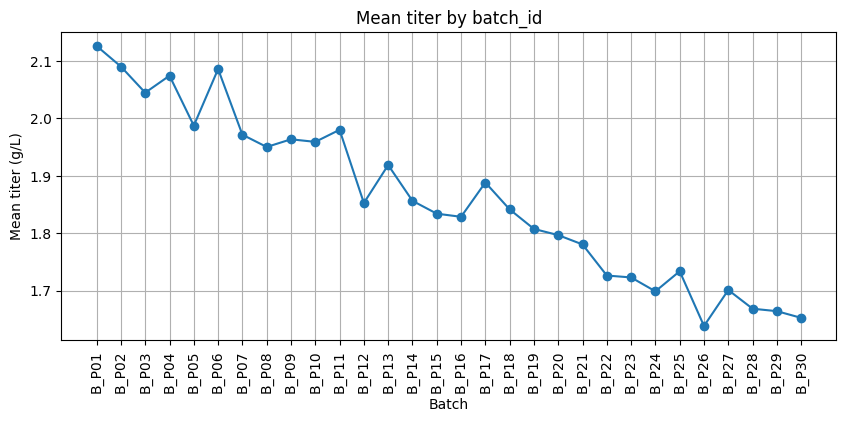

In [11]:
batch_titer = (
    assay[assay["assay_type"] == "titer"]
    .groupby("batch_id")["value"]
    .mean()
    .reset_index()
    .sort_values("batch_id")
)

batch_titer.head()

plt.figure(figsize=(10,4))
plt.plot(batch_titer["batch_id"], batch_titer["value"], marker="o")
plt.xticks(rotation=90)
plt.title("Mean titer by batch_id")
plt.xlabel("Batch")
plt.ylabel("Mean titer (g/L)")
plt.grid(True)
plt.show()

## 12) Close database connection

Good practice: close the SQLite connection when the notebook is done.

In [12]:
conn.close()
print("DB connection closed.")

DB connection closed.
